# Numerical Integration <a name="top"></a>
---
## Contents
* [Define and display integral](#define)
* [sympy.integrate](#sympy)
* [Midpoint rule](#midpoint)
* [Trapezoidal rule](#trapez)
* [Gauss–Legendre quadrature](#gauss)
* [Monte Carlo integration](#mc)
* [scipy.integrate.quad](#quad)
* [Summary](#summary)

In [1]:
# Python 3.6 or higher is needed due to the use of f-strings
# Needed to use variables in markdown and display formatted source code
from IPython.display import Markdown as md

In [2]:
import integration_helpers as ih
import sympy as sp

---
## Define and display integral <a name="define"></a>
Define $f$ as the function we want to integrate from $a$ to $b$ ($f$ has to be analytically integrable).

In [3]:
x = sp.Symbol('x')
f = sp.sin(x) * x**2
a = 7
b = 15

In [4]:
md('$$F = \int_{%s}^{%s} %s\,\mathrm{d}x$$' % (a, b, sp.latex(f)))

$$F = \int_{7}^{15} x^{2} \sin{\left(x \right)}\,\mathrm{d}x$$

Plot function and fill out the integral.

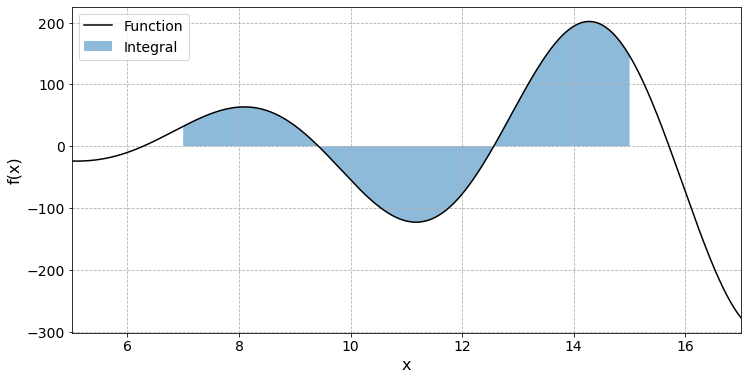

In [5]:
fn = sp.lambdify(x, f, modules='numpy')
ih.plot_int(fn, a, b)

---
## Analytical integration via *sympy.integrate* <a name="sympy"></a>
$$\int_a^b f(x)\,\mathrm{d}x = F(b) - F(a)$$
Generate a reference value for error calculations.

In [6]:
md(ih.print_function(ih.int_sympy))

```python
def int_sympy(f, a, b, x):
    F = integrate(f, x)
    F = lambdify(x, F, modules='numpy')
    return F(b) - F(a)
```

In [7]:
F_sympy = ih.int_sympy(f, a, b, x)
t_sympy = %timeit -q -o ih.int_sympy(f, a, b, x)
t_sympy = t_sympy.average * 1000

In [8]:
md('$$F_{\mathrm{sympy}} = %f$$ \n $$t_{\mathrm{sympy}} = %f\,\mathrm{ms}$$' % (F_sympy, t_sympy))

$$F_{\mathrm{sympy}} = 215.154633$$ 
 $$t_{\mathrm{sympy}} = 192.151558\,\mathrm{ms}$$

---
## Numerical integration via *midpoint rule* <a name="midpoint"></a>
$$\int_a^b f(x)\,\mathrm{d}x \approx \frac{b - a}{n} \sum_{i=1}^n f(m_i)$$
with $m_i$ as the midpoint of the $i$-th interval.

Plot function and rectangles one obtains while using the chained midpoint rule.

In [9]:
n_midpoint = 10
ih.plot_midpoint(fn, a, b, n_midpoint)

In [10]:
md(ih.print_function(ih.int_midpoint))

```python
def int_midpoint(f, a, b, n):
    width = (b - a) / n
    mi = np.arange(a + width / 2, b, width)
    return width * np.sum(f(mi))
```

In [11]:
F_midpoint = ih.int_midpoint(fn, a, b, n_midpoint)
e_midpoint = 100 * (F_midpoint - F_sympy) / F_sympy
t_midpoint = %timeit -q -o ih.int_midpoint(fn, a, b, n_midpoint)
t_midpoint = t_midpoint.average * 1000

In [12]:
md('$$F_{\mathrm{midpoint}} = %f$$ \n $$\epsilon_{\mathrm{midpoint}} = %.6e\,\%%$$ \n \
    $$t_{\mathrm{midpoint}} = %f\,\mathrm{ms}$$' % (F_midpoint, e_midpoint, t_midpoint))

$$F_{\mathrm{midpoint}} = 220.507528$$ 
 $$\epsilon_{\mathrm{midpoint}} = 2.487929e+00\,\%$$ 
     $$t_{\mathrm{midpoint}} = 0.022549\,\mathrm{ms}$$

---
## Numerical integration via *trapezoidal rule* <a name="trapez"></a>
$$\int_a^b f(x)\,\mathrm{d}x \approx \frac{b - a}{2 \cdot n} \sum_{i=1}^n f(x_{i-1}) + f(x_i)$$
Plot function and trapezoids one obtains while using the chained trapezoidal rule.

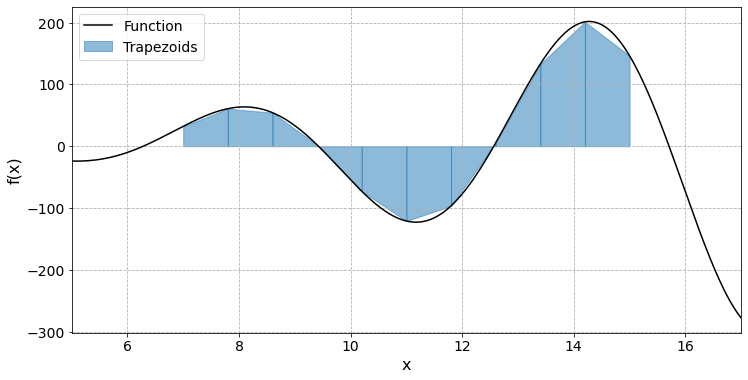

In [13]:
n_trapez = 10
ih.plot_trapez(fn, a, b, n_trapez)

In [14]:
md(ih.print_function(ih.int_trapez))

```python
def int_trapez(f, a, b, n):
    width = (b - a) / n
    xi = np.arange(a + width, b, width)
    return 0.5 * width * (f(a) + np.sum(2 * f(xi)) + f(b))
```

In [15]:
F_trapez = ih.int_trapez(fn, a, b, n_trapez)
e_trapez = 100 * (F_trapez - F_sympy) / F_sympy
t_trapez = %timeit -q -o ih.int_trapez(fn, a, b, n_trapez)
t_trapez = t_trapez.average * 1000

In [16]:
md('$$F_{\mathrm{trapez}} = %f$$ \n $$\epsilon_{\mathrm{trapez}} = %.6e\,\%%$$ \n \
    $$t_{\mathrm{trapez}} = %f\,\mathrm{ms}$$' % (F_trapez, e_trapez, t_trapez))

$$F_{\mathrm{trapez}} = 204.521496$$ 
 $$\epsilon_{\mathrm{trapez}} = -4.942091e+00\,\%$$ 
     $$t_{\mathrm{trapez}} = 0.031264\,\mathrm{ms}$$

---
## Numerical integration via *Gauss–Legendre quadrature* <a name="gauss"></a>
$$\int_a^b f(x)\,\mathrm{d}x \approx \frac{b - a}{2} \sum_{i=1}^n \omega_i \cdot f\left(\frac{b - a}{2} \xi_i + \frac{a + b}{2}\right)$$
with $\xi_i$ as the roots of the Legendre-polynomial
$$P_n(x) = \sum_{i=0}^{\left \lfloor \frac{n}{2} \right \rfloor} (-1)^k \cdot \frac{(2n-2k)!}{2^n \cdot k! \cdot (n-k)! \cdot (n-2k)!} \cdot x^{n-2k}$$
and the weights
$$\omega_i = \frac{2}{(1-\xi_i^2) \cdot P_n^\prime(\xi_i)^2}$$

In [17]:
md(ih.print_function(ih.int_gauss))

```python
def int_gauss(f, a, b, n):
    prefactors = [0] * (n + 1)
    for k in range(n // 2 + 1):
        prefactors[2 * k] = (-1)**k * factorial(2 * (n - k)) / \
                            (factorial(n - k) * factorial(n - 2 * k) * factorial(k) * 2**n)
    pol = np.poly1d(prefactors)
    dpol = pol.deriv()
    roots = pol.r
    weights = 2 / ((1 - roots**2) * dpol(roots)**2)
    return 0.5 * (b - a) * np.sum(weights * f(0.5 * (b - a) * roots + 0.5 * (a + b)))
```

In [18]:
n_gauss = 10
F_gauss = ih.int_gauss(fn, a, b, n_gauss)
e_gauss = 100 * (F_gauss - F_sympy) / F_sympy
t_gauss = %timeit -q -o ih.int_gauss(fn, a, b, n_gauss)
t_gauss = t_gauss.average * 1000

In [19]:
md('$$F_{\mathrm{gauss}} = %f$$ \n $$\epsilon_{\mathrm{gauss}} = %.6e\,\%%$$ \n \
    $$t_{\mathrm{gauss}} = %f\,\mathrm{ms}$$' % (F_gauss, e_gauss, t_gauss))

$$F_{\mathrm{gauss}} = 215.154633$$ 
 $$\epsilon_{\mathrm{gauss}} = -4.921084e-10\,\%$$ 
     $$t_{\mathrm{gauss}} = 0.391606\,\mathrm{ms}$$

---
## Numerical integration via *Monte Carlo integration* <a name="mc"></a>
$$\int_a^b f(x)\,\mathrm{d}x \approx \frac{b - a}{n} \sum_{i=1}^n f(x_i)$$
with $x_i$ as randomly sampled values in the interval $[a, b]$.

Plot function and randomly sampled lines (just for demonstration, they will not be the same in *int_mc*).

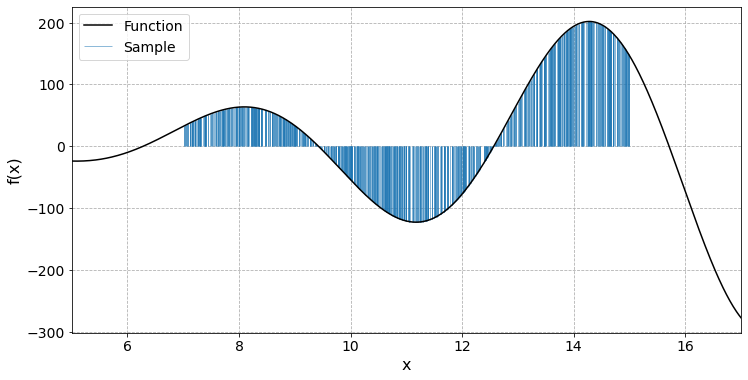

In [20]:
n_mc = 1000
ih.plot_mc(fn, a, b, n_mc)

In [21]:
md(ih.print_function(ih.int_mc))

```python
def int_mc(f, a, b, n):
    xi = uniform(a, b, n)
    return np.sum(f(xi)) * (b - a) / n
```

In [22]:
F_mc = ih.int_mc(fn, a, b, n_mc)
e_mc = 100 * (F_mc - F_sympy) / F_sympy
t_mc = %timeit -q -o ih.int_mc(fn, a, b, n_mc)
t_mc = t_mc.average * 1000

In [23]:
md('$$F_{\mathrm{MC}} = %f$$ \n $$\epsilon_{\mathrm{MC}} = %.6e\,\%%$$ \n \
    $$t_{\mathrm{MC}} = %f\,\mathrm{ms}$$' % (F_mc, e_mc, t_mc))

$$F_{\mathrm{MC}} = 226.283774$$ 
 $$\epsilon_{\mathrm{MC}} = 5.172624e+00\,\%$$ 
     $$t_{\mathrm{MC}} = 0.083587\,\mathrm{ms}$$

---
## Numerical integration via *scipy.integrate.quad* <a name="quad"></a>
The documentation states that an integration technique from the Fortran library *QUADPACK* will be used.

In [24]:
md(ih.print_function(ih.int_quad))

```python
def int_quad(f, a, b, **kwargs):
    F, _ = quad(f, a, b)
    return F
```

In [25]:
F_quad = ih.int_quad(fn, a, b)
e_quad = 100 * (F_quad - F_sympy) / F_sympy
t_quad = %timeit -q -o ih.int_quad(fn, a, b)
t_quad = t_quad.average * 1000

In [26]:
md('$$F_{\mathrm{quad}} = %f$$ \n $$\epsilon_{\mathrm{quad}} = %.6e\,\%%$$ \n \
    $$t_{\mathrm{quad}} = %f\,\mathrm{ms}$$' % (F_quad, e_quad, t_quad))

$$F_{\mathrm{quad}} = 215.154633$$ 
 $$\epsilon_{\mathrm{quad}} = 7.925939e-14\,\%$$ 
     $$t_{\mathrm{quad}} = 0.059027\,\mathrm{ms}$$

---
## Summary <a name="summary"></a>

In [27]:
md(f'<table style="width:100%;border:1px solid lightgray;text-align:right;"> \
     <tr style="border-bottom:2px solid lightgray;"><th style="text-align:left;">Method</th><th>Integral value</th><th>Error [%]</th><th>Time [ms]</th></tr> \
     <tr><th style="text-align:left;">sympy.integrate</th><th>{F_sympy:f}</th><th>-</th><th>{t_sympy:f}</th></tr> \
     <tr><th style="text-align:left;">Midpoint rule (n={n_midpoint})</th><th>{F_midpoint:f}</th><th>{e_midpoint:.6e}</th><th>{t_midpoint:f}</th></tr> \
     <tr><th style="text-align:left;">Trapezoidal rule (n={n_trapez})</th><th>{F_trapez:f}</th><th>{e_trapez:.6e}</th><th>{t_trapez:f}</th></tr> \
     <tr><th style="text-align:left;">Gauss-Legendre rule (n={n_gauss})</th><th>{F_gauss:f}</th><th>{e_gauss:.6e}</th><th>{t_gauss:f}</th></tr> \
     <tr><th style="text-align:left;">Monte Carlo integration (n={n_mc})</th><th>{F_mc:f}</th><th>{e_mc:.6e}</th><th>{t_mc:f}</th></tr> \
     <tr><th style="text-align:left;">scipy.integrate.quad</th><th>{F_quad:f}</th><th>{e_quad:.6e}</th><th>{t_quad:f}</th></tr></table>')

<table style="width:100%;border:1px solid lightgray;text-align:right;">      <tr style="border-bottom:2px solid lightgray;"><th style="text-align:left;">Method</th><th>Integral value</th><th>Error [%]</th><th>Time [ms]</th></tr>      <tr><th style="text-align:left;">sympy.integrate</th><th>215.154633</th><th>-</th><th>192.151558</th></tr>      <tr><th style="text-align:left;">Midpoint rule (n=10)</th><th>220.507528</th><th>2.487929e+00</th><th>0.022549</th></tr>      <tr><th style="text-align:left;">Trapezoidal rule (n=10)</th><th>204.521496</th><th>-4.942091e+00</th><th>0.031264</th></tr>      <tr><th style="text-align:left;">Gauss-Legendre rule (n=10)</th><th>215.154633</th><th>-4.921084e-10</th><th>0.391606</th></tr>      <tr><th style="text-align:left;">Monte Carlo integration (n=1000)</th><th>226.283774</th><th>5.172624e+00</th><th>0.083587</th></tr>      <tr><th style="text-align:left;">scipy.integrate.quad</th><th>215.154633</th><th>7.925939e-14</th><th>0.059027</th></tr></table>

---
* [Back to top](#top)
<div style="text-align: right"><a href="https://gitlab.com/wangenau/numerical_integration">Source code</a></div>
<div style="text-align: right"><span style="color:darkgray">© 2020-2021 Wanja Schulze</span></div>